# Проектная работа по теме "A/B-тестирование"

## Содержание

+ [Цель;](#objective)
+ [Описание данных;](#describe)
+ [Задачи;](#tasks)
+ Основной проект:
    + [Исследование данных;](#analysis)
    + [Оценка корректности проведения теста;](#testcheck)
    + [Проведение исследовательского анализа данных;](#analysis2)
    + [Оценка результатов A/B-тестирования;](#abtest)
    + [Финальные выводы.](#conclusion)

<a id="objective"></a>  
## Цель

Провести оценку результатов A/B-теста.

<a id="describe"></a>  
## Описание данных

**Данные**\
(Из уважения к сотрудникам Яндекс, готовящим датасеты, ссылки на них "битые")
[final_ab_events.csv](https://disk.yandex.ru/)

[ab_project_marketing_events.csv](https://disk.yandex.ru/)

[final_ab_new_users.csv](https://disk.yandex.ru/)

[final_ab_participants.csv](https://disk.yandex.ru/)

### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

<a id="tasks"></a>  
## Задачи

1) Исследовать данные;\
2) Оценить корректность проведения теста;\
3) Провести исследовательский анализ данных;\
4) Оценить результаты A/B-тестирования;\
5) Сформулировать вывод. 

<a id="analysis"></a>  
## Исследование данных

In [48]:
#импортируем все нужные бибилиотеки
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from datetime import timedelta


In [49]:
#выгрузим данные в датасеты
try:
    event = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    marketing_event = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    new_user = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
except:
    event = pd.read_csv('final_ab_events.csv')
    marketing_event = pd.read_csv('ab_project_marketing_events.csv')
    new_user = pd.read_csv('final_ab_new_users.csv')
    participants = pd.read_csv('final_ab_participants.csv')

In [50]:
#Запустим настройки бибилиотеки sns для постройки графиков в дальнейшем
sns.set()

Выведем первые 5 строк каждого из датасета.

In [51]:
event.head(5)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [52]:
marketing_event.head(5)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [53]:
new_user.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [54]:
participants.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Исходя из данных таблиц мы видим, что наименования колонок написаны в верном формате и удобны для работы. Оставим им. Посмотрим на пропуски, дубликаты данных и основную информацию по каждому из датасета.

In [55]:
#Создадим функцию, которая бы вызывала метод info, считала бы кол-во записей, прпоуски в каждой из колонок и считала бы кол-во уникальных значений
#а так же выводила бы дублирующиеся строки
def information(row):
    print('Основная информация:')
    print()
    print(row.info())
    print('*'*25)
    print(f'Количество записей : {row.shape[0]}')
    print('-'*25)
    for columns in row:
        print(f'Количество пропусков в {columns} : {row[columns].isna().sum()}')
    print('-'*25)
    for columns in row:
        print(f'Количество уникальных значений в колонке {columns} : {row[columns].nunique()}')    
    print('*'*25)
    print('Повторяющиеся строки:')
    print(row[row.duplicated()])

In [56]:
information(participants)

Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None
*************************
Количество записей : 18268
-------------------------
Количество пропусков в user_id : 0
Количество пропусков в group : 0
Количество пропусков в ab_test : 0
-------------------------
Количество уникальных значений в колонке user_id : 16666
Количество уникальных значений в колонке group : 2
Количество уникальных значений в колонке ab_test : 2
*************************
Повторяющиеся строки:
Empty DataFrame
Columns: [user_id, group, ab_test]
Index: []


В датасете, хранящий данные об участниках тестов:
+ Всего *18268* строк;
+ *Пропуски* - **отсутствуют**;
+ Всего 16666 уникальных пользователей. Кол-во записей 18268, значит, **есть дубликаты** в колонке пользователя. 
+ В колонке с группой всего *2 значения*: A и B, что соответсвует данным по условиям задачи;
+ в колонке с названием теста *2 значения* : одно с наименованием теста, который по условиям задачи нужно изучить, второй тест вне нашего обзора.

Выведем информацию по дубликатам и выведем уникальные значения по группам и наименованиям тестов.

In [57]:
print(f'Кол-во дублирующихся пользователей : {participants["user_id"].duplicated().sum()}')

Кол-во дублирующихся пользователей : 1602


**1602** пользователя встречаются несколько раз в датасете. Это может быть вызвано тем, что одни и те же пользователи *пересекаются* в разных группах или разных теста. Далее по работе проверим данную гиппотезу.

In [58]:
print(f'Уникальные значения в колонке group : {participants["group"].unique().tolist()}')
print(f'Уникальные значения в колонке ab_test : {participants["ab_test"].unique().tolist()}')

Уникальные значения в колонке group : ['A', 'B']
Уникальные значения в колонке ab_test : ['recommender_system_test', 'interface_eu_test']


Выведем оснувную информацию из датасета с новыми пользователями. 

In [59]:
information(new_user)

Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
*************************
Количество записей : 61733
-------------------------
Количество пропусков в user_id : 0
Количество пропусков в first_date : 0
Количество пропусков в region : 0
Количество пропусков в device : 0
-------------------------
Количество уникальных значений в колонке user_id : 61733
Количество уникальных значений в колонке first_date : 17
Количество уникальных значений в колонке region : 4
Количество уникальных значений в колонке device : 4
*************************
Повторяющиеся строки:
Empty DataFrame
Columns: [user_id, first_date, region, device]
Index: []


В датасете, хранящий данные об новых пользователях:
+ Всего *61733* строк;
+ *Пропуски* - **отсутствуют**;
+ Всего 61733 уникальных пользователей. Кол-во записей 61733, значит, **нет дубликатов** в колонке пользователя;
+ В колонке с датой регистрации всего *17 значений*. Некоторые пользователи заходили на сайт в одни и те же дни;
+ В колонке с названием регоина *4 значения* : проверим какие именно далее. Некоторые пользователи находятся в одних и тех же регионах;
+ В колонке с устройствоим *4 значения*: проверим какие именно далее. Некоторые пользователи заходили с одних и тех же устройств. 

In [60]:
print(f'Регионы представленные в датасете : {new_user["region"].unique().tolist()}')
print(f'Устройства представленные в датасете : {new_user["device"].unique().tolist()}')

Регионы представленные в датасете : ['EU', 'N.America', 'APAC', 'CIS']
Устройства представленные в датасете : ['PC', 'Android', 'iPhone', 'Mac']


Выведем оснувную информацию из датасета с маркетинговыми акциями. 

In [61]:
information(marketing_event)

Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
*************************
Количество записей : 14
-------------------------
Количество пропусков в name : 0
Количество пропусков в regions : 0
Количество пропусков в start_dt : 0
Количество пропусков в finish_dt : 0
-------------------------
Количество уникальных значений в колонке name : 14
Количество уникальных значений в колонке regions : 6
Количество уникальных значений в колонке start_dt : 14
Количество уникальных значений в колонке finish_dt : 14
*************************
Повторяющиеся строки:
Empty DataFrame
Columns: [name, regions, start_dt, finish_dt]
Index: []


В датасете, хранящий данные об маркетинговых акциях:
+ Всего *14* строк;
+ *Пропуски* - **отсутствуют**;
+ Всего *14* уникальных наименований акций; 
+ Всего *6* уникальных наборов регионов распространения;
+ Всего 14 дат старта и 14 дат окончания.

Выведем оснувную информацию из датасета с действиями пользователей.

In [62]:
information(event)

Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
*************************
Количество записей : 440317
-------------------------
Количество пропусков в user_id : 0
Количество пропусков в event_dt : 0
Количество пропусков в event_name : 0
Количество пропусков в details : 377577
-------------------------
Количество уникальных значений в колонке user_id : 58703
Количество уникальных значений в колонке event_dt : 267268
Количество уникальных значений в колонке event_name : 4
Количество уникальных значений в колонке details : 4
*************************
Повторяющиеся строки:
Empty DataFrame
Columns: [user

В датасете, хранящий данные об новых пользователях:
+ Всего *440317* строк;
+ *Пропуски* - **присутствуют** в колонке с дополнительной информацией. Сама по себе колонка не имеет серьезного значения в анализе, а носит характер заметок. В зависимости от действия, оператор вносит различную информацию дополнительную. Так как колонка не имеет существенного веса, пропуски оставляем;
+ Всего 58703 уникальных пользователей. Кол-во записей 440317, значит, **есть дубликаты** в колонке пользователя;
+ В колонке с датой  *267268 пар значений*. Некоторые пользователи совершали действия в один и тот же день;
+ В колонке с названием действия *4 значения* : проверим какие именно далее;
+ В колонке с дополнительной информацией *4 значения*: проверим какие именно далее. 

In [63]:
print(f'Уникальные значения действий пользователей : {event["event_name"].unique().tolist()}')
print(f'Уникальные значения в дополнительной информации : {event["details"].unique().tolist()}')

Уникальные значения действий пользователей : ['purchase', 'product_cart', 'product_page', 'login']
Уникальные значения в дополнительной информации : [99.99, 9.99, 4.99, 499.99, nan]


Если присматриваться в *тип данных*, то заметим, что колонки, хранящие информацию о датах выражена в формате **объект**. Преобразуем в формат **дата**.

In [64]:
#Преобразуем колонки с датой в формат даты. 
event['event_dt'] = pd.to_datetime(event['event_dt']).dt.date
event['event_dt'] = pd.to_datetime(event['event_dt'])
marketing_event['finish_dt'] = pd.to_datetime(marketing_event['finish_dt'])
marketing_event['start_dt'] = pd.to_datetime(marketing_event['start_dt'])

<a id="testcheck"></a>  
## Оценка корректности проведения теста

Прежде, чем начать проверку, определим идентификаторы пользователей, которые нужны для анализа. Разобьем эту операцию на шаги:
1) Возьмем информацию по новым пользователям и отсортируем её по времени и по региону. Так, мы получим информацию по пользователям, которые зарегистрировались в период **до  2020-12-21** и **из Европы**;\
2) Сохранив данные пользователей, отфильтруем данные в датасете с данными участников тестов. Отфилтруем только тех, кто учавствовал в recommender_system_test. Добавим фильтрацию из первого пункта. То есть оставляем таким образом пользователей, которые регистрировались до 2020-12-21, из Европы и **учавствовал в тесте recommender_system_test**;\
3) Следующим шагом будет фильтрация по пользователям из таблицы с действиями. Сгруппируем данные по *количеству* действий и посчитаем тех пользователей, которые совершали **хотя бы одно действие**. Таким образом, собрав все данные в одну таблицу, получим финальный список пользователей. 

In [65]:
#отфильтруем из таблицы с пользователями по дате и по региону и сохраним данные в новый датасет
new_user_date = new_user[new_user['first_date'] <= '2020-12-21']
new_user_eu = new_user_date[new_user_date['region'] == 'EU']
print(f'Количество пользователей после сортировки : {new_user_eu["user_id"].nunique()}')

Количество пользователей после сортировки : 42340


In [66]:
#отфильтруем из таблицы с данными участников тестов
participants_test = participants[participants['ab_test'] == 'recommender_system_test']
#присоединим в новый датасет два отфильтрованных датасета
data_user_eu = new_user_eu.merge(participants_test)
print(f'Количество пользователей после сортировки : {data_user_eu["user_id"].nunique()}')

Количество пользователей после сортировки : 6351


In [67]:
#отфильтруем данные по датасету с действиями пользователей
#По условиям задачи временные рамки исследования с 7 декабря 2020 по 4 января 2021. Отфильтруем для начала по дате
event_date = event.query('(event_dt >= "2020-12-07") & (event_dt <= "2021-01-04")')
event_date

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07,purchase,99.99
1,7B6452F081F49504,2020-12-07,purchase,9.99
2,9CD9F34546DF254C,2020-12-07,purchase,4.99
3,96F27A054B191457,2020-12-07,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30,login,NaN
440313,9385A108F5A0A7A7,2020-12-30,login,NaN
440314,DB650B7559AC6EAC,2020-12-30,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30,login,NaN


In [68]:
#теперь сгруппируем по кол-ву действий и отбросим тех, кто не совершал вообще действий.
event_raw_pivot = event_date.pivot_table(index='user_id', values='event_name', aggfunc='count').reset_index()
event_raw_pivot = event_raw_pivot[event_raw_pivot['event_name'] > 0]
event_raw = event_date[event_date['user_id'].isin(data_user_eu['user_id'])]
print(f'Количество пользователей после сортировки : {event_raw_pivot["user_id"].nunique()}')

Количество пользователей после сортировки : 58703


Теперь "схлопнем" получившиеся датасеты и оставим только тех пользователей, которые останутся после всех трех фильтраций. 

In [69]:
data_user_eu = data_user_eu.merge(event_raw, on='user_id')
#избавимся от колонки с доп информацией, она нам не понадобится
data_user_eu = data_user_eu.drop(columns='details', axis=1)
print(f'Количество пользователей после сортировки : {data_user_eu["user_id"].nunique()}')

Количество пользователей после сортировки : 3481


In [70]:
data_user_eu.head(5)

,user_id,first_date,region,device,group,ab_test,event_dt,event_name
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,product_page
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07,login
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07,product_page
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08,product_page
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10,product_page


Таким образом, после учёта всех условий проекта, финальное количество пользователей равно **3481**. Ожидаемое количество по ТЗ - **6000** пользователей. Можем сделать вывод о том, что *количество исследуемых пользователей не соответветствует ТЗ*.

Следующим пунктом проверки ТЗ является проверка *даты остановки новых пользователей*. 

In [71]:
#Фильтруем по региону
user_check = new_user[new_user['region'] == 'EU']
#оставляем только тех пользователей, которые учавствовали в нужно тесте из датасета participants_test
user_check = user_check[user_check['user_id'].isin(participants_test['user_id'])]
#Выводим самую крайнюю дату регистрации 
print(f'Самая поздняя дата регистрации пользователя : {max(user_check["first_date"])}')

Самая поздняя дата регистрации пользователя : 2020-12-21


Таким образом, ТЗ в части проверки даты регистрации *можно считать выполненным*.

Следующим пунктом проверки ТЗ является проверка *15% пользователей из Евросюза участвуют в тесте*. 

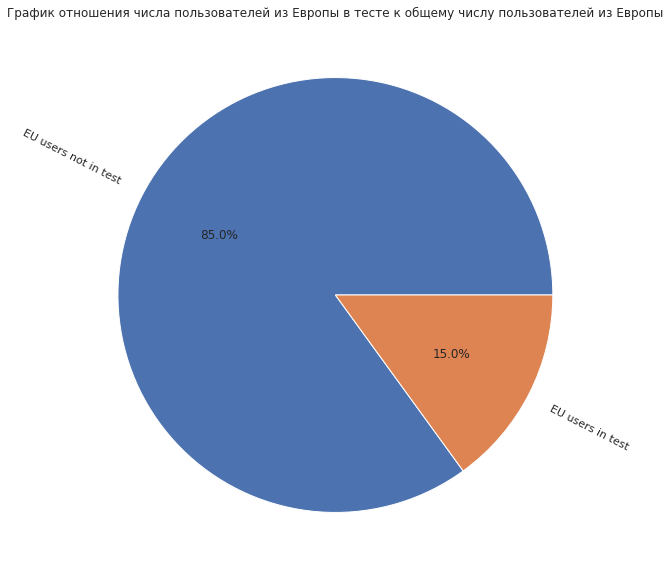

In [72]:
#Ранее мы уже отсортировали пользователей из Европы, которые регистрировались в период исследования. Теперь сравним кол-во пользователей
#которые регистрировались в эти же периоды, но являлись участниками теста. 
#Построим круговую диагрмму
#Сохраним в список сначала число пользователей из Европы, которые НЕ участвуют в тесте, потом тех, кто участвует и построим диаграмму
qty_users = [(new_user_eu['user_id'].nunique() - user_check['user_id'].nunique()), user_check['user_id'].nunique()]

labels = ['EU users not in test', 'EU users in test']
plt.figure(figsize =(10,10))
plt.pie(qty_users, labels=labels, autopct='%1.1f%%',rotatelabels=True)
plt.title('График отношения числа пользователей из Европы в тесте к общему числу пользователей из Европы')
None

На основе данного графика мы видим, что порядка **15%** новых пользоваталей из Европы участвуют в тесте среде всех пользователей из Европы. Таким образом, ТЗ в части доли новых пользователей *выполненно*. 

ТЗ по части изменения конверсии мы рассмотрим далее по проекту.

Проверим, не совпадало ли время проведения теста с временем проводимых маркетинговых операций.

In [73]:
#отфильтруем данные по региону и оставим только те, которые проходили в Евросоюзе. так же отфильтруем по дате:
#старт или финиш промо должны быть в диапазоне прводения теста.
#Исключим так же ситуацию, при которой промо проводилось ранее даты проведения теста и закончилась позже даты окончания
#Фильтруем по региону
marketing_event_eu = marketing_event[marketing_event['regions'].str.contains('EU')]
#Фильтруем по дате
marketing_event_eu = marketing_event_eu.query('("2020-12-07" <= finish_dt <= "2021-01-04") or ("2020-12-07" <= start_dt <= "2021-01-04")')
#Фильтруем исключения по дате 
marketing_event_eu_a = marketing_event_eu.query('("2020-12-07" >= start_dt) & (finish_dt >= "2021-01-04")')
print('Промо проводимые в пределах теста:')
display(marketing_event_eu)
print()
print('Промо проводимые дольше времени проведения теста:')
display(marketing_event_eu_a)

Промо проводимые в пределах теста:


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03



Промо проводимые дольше времени проведения теста:


,name,regions,start_dt,finish_dt


Таким образом, рождественская и новогодняя промо проводилась *во время* проведения теста. Этот факт мог сильно повлиять на поведение пользователей. 

Проверим, есть ли пересечение пользователей в тестах. 

In [74]:
#Оставляем в сырых данных только пользователей, которые удовлетворяли условиям
participants_test_check = participants[participants['user_id'].isin(data_user_eu['user_id'])]
#группируем по пользователям и считаем количество тестов.
participants_test_check = participants_test_check.pivot_table(index='user_id', values='ab_test', aggfunc='count').reset_index()
print(f'Число пользователей проходящих в двух тестах : {participants_test_check[participants_test_check["ab_test"] > 1].shape[0]}')
participants_test_check = participants_test_check[participants_test_check['ab_test'] > 1]

Число пользователей проходящих в двух тестах : 887


Пересечения в тестах **есть**. Мы не знаем, какие вводные данные у второго теста, поэтому говорить о том, что нахождение пользователя в двух тестах сразу *не влияет на результат* мы не можем. Проверим, есть пользователи, которые находятся сразу в двух группах. 

In [75]:
#повторим процедуру , но посчитаем группы
participants_ab_check = participants[participants['user_id'].isin(data_user_eu['user_id'])]
participants_ab_check = participants_ab_check.pivot_table(index='user_id', values='group', aggfunc='count').reset_index()
print(f'Число пользователей проходящих в двух тестах : {participants_ab_check[participants_ab_check["group"] > 1].shape[0]}')
participants_ab_check = participants_ab_check[participants_ab_check['group'] > 1]

Число пользователей проходящих в двух тестах : 887


Пересечения так же есть и в группах, причем такое же количество. Этот факт сильно влияет на результат теста, поэтому для удобства уберем этих пользователей из финального списка пользователей. Но для начала сверим списки этих двух фильтров: являются ли эти юзеры одними и теми же. 

In [76]:
#Соединим два датасета между собой и посчитаем нули в полученных ячейках. Если нулей не будет, значит пользователи находятся
#в обеих  группах теста и в двух тестах одновременно. 
participants_check = participants_test_check.merge(participants_ab_check, on='user_id')
participants_check[['ab_test', 'group']].isna().sum()

ab_test    0
group      0
dtype: int64

Таким образом, пользователи, *находящиеся в двух тестах* одновременно находятся в *двух тестовых группах* одновременно. Другими словами, категоризация этих пользователей зависит от проводимого теста: в одном тесте они подходят под криетрии группы **А**, а при другом **B**. Такое пересечение сильно влияет на результат A/B теста, поэтому уберем этих пользователей из корректной группы сравниваемых пользователей. 

In [77]:
data_user_eu = data_user_eu[~data_user_eu['user_id'].isin(participants_check['user_id'])]
print(f'Количество пользователей после сортировки : {data_user_eu["user_id"].nunique()}')

Количество пользователей после сортировки : 2594


Следующая проверка - это равномерность распределения пользователей по группам. 

In [78]:
#Сгруппируем по группе и посчитаем уникальное число пользователей в каждой из них.
data_user_eu_group = data_user_eu.pivot_table(index='group', values='user_id', aggfunc='nunique').reset_index().\
    sort_values(by='user_id', ascending=False)
display(data_user_eu_group)
#Визуаилизируем
fig = px.pie(data_user_eu_group, values='user_id', names='group', title='График сравнения количества пользователей по группам')
fig.show()

,group,user_id
0,A,1939
1,B,655


Исходя из полученных данных, можем указать на **неравномерность** распределения по группам : число пользователей из группы *А* **больше** группы *B* на порядок - *75%* против *25%* пользователей соответственно. Равномерность распредления долей мы проверим далее по проекту. 

Посмотрим, как менялось количество действий в каждой из группы по времени.

In [79]:
#сгруппируем данные по дате действия и по группе и посчитаем число пользователей
data_user_eu_dt = data_user_eu.pivot_table(index=['event_dt', 'group'], values='event_name', aggfunc='count').reset_index()
data_user_eu_dt['event_dt'] = data_user_eu_dt['event_dt'].dt.date

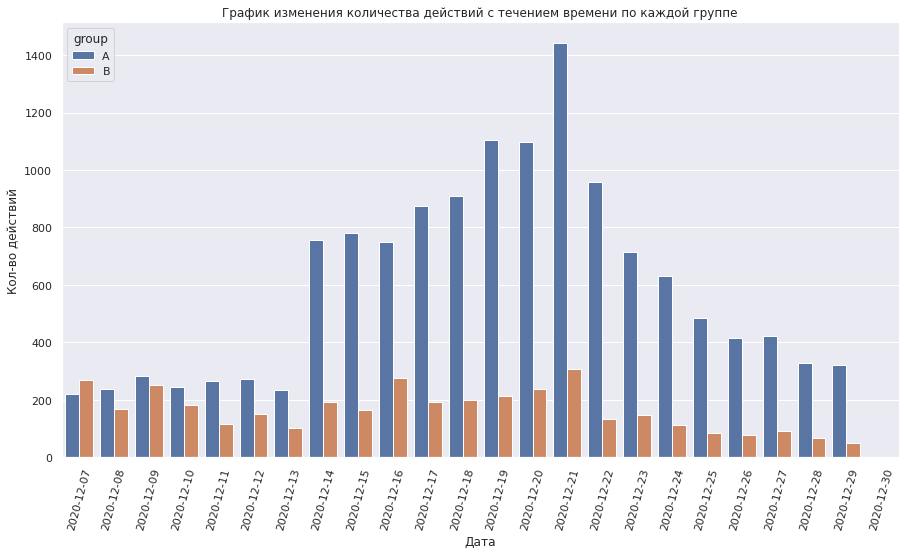

In [80]:
#построим график изменения с течением времени изменения количества действий
plt.figure(figsize=(15,8))
sns.barplot(data=data_user_eu_dt, x='event_dt', y='event_name', hue='group')
plt.title('График изменения количества действий с течением времени по каждой группе')
plt.xlabel('Дата')
plt.ylabel('Кол-во действий')
plt.xticks(rotation=75)
plt.show()

На основании графика мы видим, что с *7 декабря 2020 по 10 декабря* число действий в среднем было равно между группами.\
с *11 декабря* начинается падение действий группы **B**, а с *14 декабря* виден резкий рост количества действий группы *А* и достигает своего пика *21 декабря*. После чего начинает своё падение и заканчивается *29 декабря*. Стоит отметить, что после *29 декабря* не было совершено ни одного действия исследуемых пользователей.\
За весь период исследования группа *B* не показывала существенного роста количества действий. Это может быть следствием нескольких причин:

1) Число пользователей из группы *А* начало расти с *14 декабря* и тем самым общее число действие выросло;\
2) Пользователи, регистрирующиеся в начале исследования пробовали новую систему, которая не понравилась или имела технические проблемы, решали совершать покупки в старой системе;\
3) Число новых пользователей группы *B* росло равномерно, но огромное число пользователей уходило после процесса регистрации. 

В любом случае, на данном графике видна неэффективность перемен, на что стоит обратить внимание руководство. 

Проверим ситуацию, при которой пользователи совершали действия более, чем за 14 дней после даты регистрации. 

In [81]:
#Добавим новый столбец с числом дней, прошедших с момента регистрации пользователя и отфильтруем те строки, в которых дней прошло больше 14
data_user_eu['first_date'] = data_user_eu['first_date'].astype('datetime64')
data_user_eu['days'] = data_user_eu['event_dt'] - data_user_eu['first_date']
data_user_eu_out = data_user_eu[abs(data_user_eu["event_dt"]-data_user_eu["first_date"])>timedelta(days=14)]
print(f'Пользователей, чья продуктовая воронка выходит за пределы 14 дней : {data_user_eu_out["user_id"].nunique()} штук')

Пользователей, чья продуктовая воронка выходит за пределы 14 дней : 191 штук


Целых 191 пользователь совершал действия, которые выходили за рамки ТЗ. Но нам необходимо не удалить таких пользователей, а только такие действия.

In [82]:
#Оставляем только те строки, действия которые не выходят за рамки 14 дней.
data_user_eu = data_user_eu[data_user_eu['days'] <= timedelta(days=14)]

<a id="analysis2"></a>  
## Проведение исследовательского анализа данных

Исследовательский анализ начнем с проверки равномерности распределения количества событий на одного пользователя. 

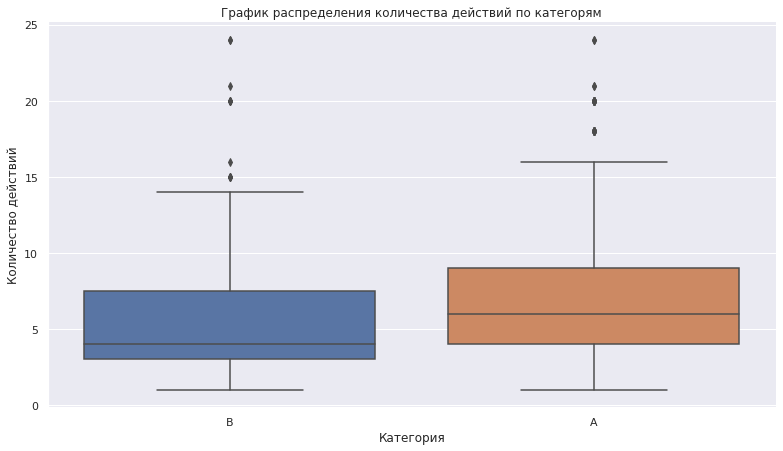

In [83]:
#Сгруппируем данные по пользователям и группам и посчитаем количество действий на каждого
data_user_eu_event = data_user_eu.pivot_table(index=['user_id', 'group'], values='event_name', aggfunc='count').reset_index().\
    sort_values(by='event_name', ascending=False)
#Нарисуем график для удобства 
sns.catplot(data=data_user_eu_event, x="group", y = 'event_name', kind="box", height=6, aspect= 1.8)
plt.title('График распределения количества действий по категорям')
plt.xlabel('Категория')
plt.ylabel('Количество действий')
plt.show()

In [84]:
#Добавим методом describe распределение по каждой группе
groups = data_user_eu_event['group'].unique()
for groupa in groups:
    print(f'Распределение количества действий в группе {groupa}')
    display(data_user_eu_event[data_user_eu_event['group'] == groupa]['event_name'].describe())
    print(f'Медианное значение:{data_user_eu_event[data_user_eu_event["group"] == groupa]["event_name"].median()}')
    print()

Распределение количества действий в группе B


count    655.00000
mean       5.49313
std        3.34822
min        1.00000
25%        3.00000
50%        4.00000
75%        7.50000
max       24.00000
Name: event_name, dtype: float64

Медианное значение:4.0

Распределение количества действий в группе A


count    1939.000000
mean        6.956679
std         3.862334
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
Name: event_name, dtype: float64

Медианное значение:6.0



На основании полученного графика можем сделать вывод о том, что в *в среднем* число действий клиентов группы *А* и группы *B* **различаются**. Так как на первом графике мы видим, что присутствуют *аномальные выбросы* в части количества действий, правильным будет выбрать медианное значение. Таким образом, в среднем пользователи группы *А* совершают **больше** действий, чем группа **B** на 2 действия. На данном этапе можно уже сделать предположение, что пользователи группы *А* намного вероятнее доходят до стадии *покупки*. Однако по анализу у нас всего 4 действия. Такое несовпадение количества может говорить о том, что пользователи первой группы в среднем больше пользуются сайтом и чаще просматривают различные карточки продуктов, в отличае от группы *B*. Либо интерфейс сайта не понятен пользователям, поэтому им приходится повторять одни и те же действия и так далее. 

Исследуем продуктовую воронку всех пользователей. 

In [85]:
#Сгруппируем данные по названию действия и посчитаем уникальное число пользователей их совершивших

data_user_eu_trace = data_user_eu.pivot_table(index='event_name', values='user_id', aggfunc='nunique').reset_index()
#Создадим функцию, которая бы возвращала порядковый номер действия в соответствие с логикой покупки
def order(row):
    if row == 'login':
        return 1
    elif row == 'product_page':
        return 2
    elif row == 'product_cart':
        return 3
    else:
        return 4
#создадим колонку с порядковым номером
data_user_eu_trace['order'] = data_user_eu_trace['event_name'].apply(order)    
#отфильтруем по порядкову номеру действия
data_user_eu_trace = data_user_eu_trace.sort_values(by='order')

In [86]:
#построим график
fig = go.Figure()
fig.add_trace(go.Funnel(
    
    y = data_user_eu_trace['event_name'],
    x = data_user_eu_trace['user_id'],
    marker = {"color": "#3274a1"},
    textinfo = "value+percent initial"))
fig.update_layout(
    template = "simple_white",
    title={'text': "Воронка общая"},
    width=900,
    height=500
)

fig.show()

Исходя из построенной воронки можем сделать выводы о тестовой группе:

1) 31% пользователей доходит до стадии *покупка*;\
2) Некоторые пользователи доходят до стадии *покупка* **обходя** продуктовую корзину;\
3) 63% пользователей доходят до стадии страницы покупки.

Рассмотрим воронку по каждой из группы.\
Для группы А

In [87]:
data_user_eu_trace_a = data_user_eu[data_user_eu['group'] == 'A'].\
    pivot_table(index='event_name', values='user_id', aggfunc='nunique').reset_index()
data_user_eu_trace_a['order'] = data_user_eu_trace_a['event_name'].apply(order)
data_user_eu_trace_a = data_user_eu_trace_a.sort_values(by='order')

fig = go.Figure()
fig.add_trace(go.Funnel(
    
    y = data_user_eu_trace_a['event_name'],
    x = data_user_eu_trace_a['user_id'],
    marker = {"color": "#3274a1"},
    textinfo = "value+percent initial"))
fig.update_layout(
    template = "simple_white",
    title={'text': "Воронка группы А"},
    width=900,
    height=500
)

fig.show()

Для группы B.

In [88]:
data_user_eu_trace_b = data_user_eu[data_user_eu['group'] == 'B'].\
    pivot_table(index='event_name', values='user_id', aggfunc='nunique').reset_index()
data_user_eu_trace_b['order'] = data_user_eu_trace_b['event_name'].apply(order)
data_user_eu_trace_b = data_user_eu_trace_b.sort_values(by='order')

fig = go.Figure()
fig.add_trace(go.Funnel(
    
    y = data_user_eu_trace_b['event_name'],
    x = data_user_eu_trace_b['user_id'],
    marker = {"color": "#3274a1"},
    textinfo = "value+percent initial"))
fig.update_layout(
    template = "simple_white",
    title={'text': "Воронка группы B"},
    width=900,
    height=500
)

fig.show()

Сравнивая воронки двух групп, можем сделать вывод о том, что группа *B* **отстаёт** от группы *A* по всем этапам:

1) 65% группы *А* доходит до страницы продукта против 56% группы *B*;\
2) И в группе *А* и в группе *В* некоторые пользователи доходили до стадии покупки обходя продуктовую корзину;\
3) 32% пользователей *А* дошли до стадии *покупки* против 29% группы *В*.

В целом, можно сделать промежуточный вывод о том, что новая система *не эффективна* в формате анализа продуктовой воронки. 

Координально картина не поменялась, группа *B* всё так же показывает **хуже результат**, чем группа *А* с каждым шагом конверсии, тем самым это указывает на неэффективность новой системы и не соответсвие одного из пунктов ТЗ.

Таким образом, можно сказать, что данные для анализа клиентов имеют большое число недочётов и несоответствий ТЗ.\
При фильтрации данных согласно условиям мы получаем:

1) Аудитория: 15% новых пользователей из региона EU - **не выполнена**;\
2) Ожидаемое количество участников теста: 6000 - **не выполнена**;\
3) За 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10% - **не выполнена**;\
4) Время проведения теста не совпадает с маркетинговыми и другими активностями - **не выполнена**;\
5) Нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно - **не выполненно**;\
6) Количество событий на пользователя одинаково распределены в выборках - **не выполнено**;\
7) Количество действий распределено по дням **не равномерно**;\
8) Конверсия в воронке в выборках на разных этапах **не показала улучшение у новой группы**.

На данном этапе можно говорить о некорректной подготовке данных для анализа A/B теста и не эффективности новой системы. В следующем пункте мы проведем A/B тест с пользователями, удовлетворяющих ТЗ и проведем тест о равенстве долей между группой А и B. 

<a id="abtest"></a>  
## Оценка результатов A/B-тестирования

Прежде, чем провести анализ A/B тестирования, проверим равенство долей между группами по очищенным данным с помощью z-теста. 

In [89]:
#определим размер выборки группы А
len_a = data_user_eu[data_user_eu['group'] == 'A'].shape[0]    
#определим размер выборки группы B
len_b = data_user_eu[data_user_eu['group'] == 'B'].shape[0]
#общая длина массива
total = len_a + len_b
#вызовем Z тест
proportions_ztest([len_a, len_b], [total, total])

(107.00948894893696, 0.0)

Как мы видим, *среднее отличие пропорций* между группами довольно большое, а p_value не удовлетворяет минимальной границе проверки (0.05). Тем самым можем сказать, что **статистическая разница долей присутсвует**. При условии уже выявленных недочетов проведения теста, проверим равенство долей на каждом из этапов.

In [90]:
#Создадим функцию, которая бы фильтровала датасет по группе сравнения, группировала по названию действия и считала число уникальных
#пользователей, совершивших это действие. 
def groupping(row):
    data_1 = data_user_eu[data_user_eu['group'] == row]\
            .groupby('event_name')\
            .agg({'user_id':'nunique'})\
            .reset_index()\
            .sort_values(by='user_id', ascending=False)
    #добавляем столбец с общим числом пользователей в фильтруемой группе
    data_1['total'] = len(data_user_eu[data_user_eu['group'] == row]['user_id'].unique())
    #Считаем долю пользователей, совершивших действие от общего числа пользователей
    data_1['share'] = round(
        (data_1['user_id'] / data_1['total'])*100,2) 
    #считаем изменение доли пользователей по сравнению с прошлым шагом
    data_1['share_change'] = round((data_1['user_id']/data_1['user_id'].shift())*100, 2)
    #заполним самую первую итарацию изменения доли первого шага на 100% , так как до этого шага не было других шагов
    data_1['share_change'] = data_1['share_change'].fillna(100)
    return data_1   

In [91]:
#Формируем таблицу с группой A
data_a = groupping('A')
#Формируем таблицу с группой B
data_b = groupping('B')

In [92]:
#Отсортируем по порядку событий
data_a['order'] = data_a['event_name'].apply(order)    
data_a = data_a.sort_values(by='order').reset_index()
data_b['order'] = data_b['event_name'].apply(order)    
data_b = data_b.sort_values(by='order').reset_index()

Проведем A/B тест.

Сформулируем гипотезы:

**Н0**: между долями в событиях в группах нет разницы\
**Н1**: между долями в событиях в группах есть разница

In [93]:
#Для удобства проведения теста создадим функцию.
#Передадим переменной events_unique уникальные значения событий, по которым требуется провести тест. Нас интересуют три.

events_unique =    data_a['event_name'].unique().tolist()
#Фкнции передадим 4 переменные:
#1)данные с первой группой
#2)данные со второй группы
#3)критический уровень статитистической значимости. Принято выбирать значения в 0.05 или в 0.01. Для более обширного теста возьмем значение 0.05
#4)коэфициент поправки на кол-во пар сравений. Данный показатель будет учавстсовать в проверке p_value и alpha, деленное на это кол-во.
def stattest_groups(df_1, df2, alpha, adjustment):
    
    for value in range(len(events_unique)):
        count = [df_1['user_id'][value], df2['user_id'][value]]
        nobs = [df_1['total'][0], df2['total'][0]]
        stat, pval = proportions_ztest(count, nobs)
        print()
        print(f'P_value на стадии {events_unique[value]} равен:')
        print(round(pval, 4))
        if pval < alpha/adjustment:
            print('Отвергаем нулевую гипотезу, между долями есть разница.')
        else:
            print('Не отвергаем нулевую гипотезу, между долями нет разницы.')

In [94]:
#Выведем результат теста сравнения групп A и B без учёта поправки на кол-во пар сравнения
stattest_groups(data_a, data_b, 0.05, 4)


P_value на стадии login равен:
0.0853
Не отвергаем нулевую гипотезу, между долями нет разницы.

P_value на стадии product_page равен:
0.0
Отвергаем нулевую гипотезу, между долями есть разница.

P_value на стадии product_cart равен:
0.269
Не отвергаем нулевую гипотезу, между долями нет разницы.

P_value на стадии purchase равен:
0.2404
Не отвергаем нулевую гипотезу, между долями нет разницы.


На основании результата тестов можем сделать вывод о том, что тест *требует повторного проведения или доработок*. На всех стадиях мы видим, что группы не отличаются, кроме стадии *страницы продукта*. Тест показал сильное отличие долей, плюс ранее мы изучили воронку событий и убедились, что сильнейшая разница между долями присутствует именно на этом этапе : количество пользователей на стадии перехода на страницу с продуктом из группы *B* ушло **больше**, чем из группы *А*. Это и показал z-тест. Однако все последующие этапы показали **отсутствие** разницы между группами.

Таким образом, можем говорить о том, что A/B тест можно признать **не удачным**. Разница между группами была замечена только на стадии изучения изменения конверсии пользователей при переходе на страницу с товаром. Этого недостаточно для полноценного вывода о том, что новая система только ухудшила состояние.  Требуется совершить следующие шаги:

1) Более чётко сформулировать принцип деления пользователей на группы;\
2) Следить за тем, чтобы на действия пользователей не влияли внешние факторы : технические перебои работы альтернативной системы, маркетинговые мероприятия, акции и прочее;\
3) Следить за тем, чтобы группы *не пересекались*;\
4) Следить за тем, чтобы пользователи *не были участниками* сразу нескольких тестовых групп;\
5) Следить за тем, чтобы статистического различия долей *не было*;\
6) Увеличить число пользователей в тестовых группах или увеличить период тестирования. 

Этот минимальный набор требований необходим для успешного проведения A/B теста. На данном этапе A/B тест *можно считать не удачным*. Требуется повторное проведение теста.\
При прочих равных условиях можем сделать **предположение**, что новая система не эффективна и потеря клиентов на стадии перехода на страницу с товаром не случайна. Это может быть причиной не только прямой неудачной интеграции новой системы, но внешние факторы : так как тест попал на рождественскую и новогоднюю акцию, пользователи уходили с ресурса на стадии страницы товара из-за высокой цены (конкуренты давали новогодние акции, скидки, которых не было у исследуемой компании). Зачастую даже минимальная скидка уже более сильно располагает клиента к покупке, особенно когда он этого ожидает (праздники). Другим внешним фактором может быть неудачный выбор периода теста. Конец года не лучший вариант для изменений : предновогодняя рабочая суета, отпуска и так далее. В качестве рекомендаций благоприятным временем для тестов является пост-новогодний период - начало Февраля. Так же стоит рассмотреть более детально причины отсутствия активности уже 30 декабря, хотя тест проводился до 4 января. Скорее всего, новых клиентов набралось недостаточное количество и их приход был слишком неравномерным, что все действия они совершали до 30 декабря. В таком случае, нужно проверить техническое  состояние сайта в эти дни : новые пользователи под конец года не могли зарегистрироваться и так далее. Либо причина в том, что 14 дней в качестве выбора жизненного цикла слишком мал для анализа. Возможно из-за особенностей товара клиенту требуется больше времени на обдумывание и принятие решения. Возможно, стоит увеличить lifetime до 3-4 недель. 

<a id="conclusion"></a>  
## Вывод

При выгрузке данных была проведена предварительная подготовка данных к анализу: 
1) Были выявлены пропуски. Было решено их оставить, так как их наличие не влияло на результат анализа;\
2) Некоторые колонки с данными были приведены к нужному формату данных для дальнейшего анализа. 

Данные для анализа клиентов имеют большое число недочётов и несоответствий ТЗ.\
При фильтрации данных согласно условиям мы получили:

1) Аудитория: 15% новых пользователей из региона EU - **выполнена**;\
2) Ожидаемое количество участников теста: 6000 - **не выполнена**;\
3) За 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10% - **не выполнена**. Новая группа показала результат хуже;\
4) Время проведения теста не совпадает с маркетинговыми и другими активностями - **не выполнена**. Пересечения присутствуют;\
5) Нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно - **не выполненно**. Пересечения присутствуют;\
6) Количество событий на пользователя одинаково распределены в выборках - **не выполнено**;\
7) Количество действий распределено по дням **не равномерно**;\
8) Конверсия в воронке в выборках на разных этапах **не показала улучшение у новой группы**.

На данном этапе можно говорить о некорректной подготовке данных для анализа A/B теста и сделать предположение об неэффективности новой системы. 

A/B тест можно признать **не удачным**. Разница между группами была замечена только на стадии изучения изменения конверсии пользователей при переходе на страницу с товаром. Этого недостаточно для полноценного вывода о том, что новая система только ухудшила состояние.  Требуется совершить следующие шаги:

1) Более чётко сформулировать принцип деления пользователей на группы;\
2) Следить за тем, чтобы на действия пользователей не влияли внешние факторы : технические перебои работы альтернативной системы, маркетинговые мероприятия, акции и прочее;\
3) Следить за тем, чтобы группы *не пересекались*;\
4) Следить за тем, чтобы пользователи *не были участниками* сразу нескольких тестовых групп;\
5) Следить за тем, чтобы статистического различия долей *не было*;\
6) Увеличить число пользователей в тестовых группах или увеличить период тестирования. 

Этот минимальный набор требований необходим для успешного проведения A/B теста. На данном этапе A/B тест *можно считать не удачным*. Требуется повторное проведение теста.\
При прочих равных условиях можем сделать **предположение**, что новая система не эффективна и потеря клиентов на стадии перехода на страницу с товаром не случайна. Это может быть причиной не только прямой неудачной интеграции новой системы, но внешние факторы : так как тест попал на рождественскую и новогоднюю акцию, пользователи уходили с ресурса на стадии страницы товара из-за высокой цены (конкуренты давали новогодние акции, скидки, которых не было у исследуемой компании). Зачастую даже минимальная скидка уже более сильно располагает клиента к покупке, особенно когда он этого ожидает (праздники). Другим внешним фактором может быть неудачный выбор периода теста. Конец года не лучший вариант для изменений : предновогодняя рабочая суета, отпуска и так далее. В качестве рекомендаций благоприятным временем для тестов является пост-новогодний период - начало Февраля. Так же стоит рассмотреть более детально причины отсутствия активности уже 30 декабря, хотя тест проводился до 4 января. Скорее всего, новых клиентов набралось недостаточное количество и их приход был слишком неравномерным, что все действия они совершали до 30 декабря. В таком случае, нужно проверить техническое  состояние сайта в эти дни : новые пользователи под конец года не могли зарегистрироваться и так далее. Либо причина в том, что 14 дней в качестве выбора жизненного цикла слишком мал для анализа. Возможно из-за особенностей товара клиенту требуется больше времени на обдумывание и принятие решения. Возможно, стоит увеличить lifetime до 3-4 недель. 